### **Comparing cosine and von mises tuning models**

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys
import os

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from session_utils import getTrainTest, getBlockConstraints, get_Sessions
from CosineTuning import *
from lineplots import plotsd
from sklearn.model_selection import KFold
from plotting_utils import figSize


min_nblocks    = 3
participant    = 'T5'

FILE_DIR       = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/' + participant + '/'
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
filelist       = glob.glob(FILE_DIR + 'historical/*')

block_constraints = None #getBlockConstraints(FILE_DIR)
files             = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)

In [7]:
np.nan

nan

In [8]:
from session_utils import getFields


figSize(7, 15)
np.random.seed(41)


# general settings: 
fields = ['TX', 'cursorPos', 'targetPos']
task   = None
blocks = None

# Tuning curve plotting:
n_bins     = 15
n_iters    = 1000


cos_data = dict()
cos_data['tuning']     = np.zeros((2, 192, 3))  # r_0 (baseline), alpha (modulation), theta (preferred dir)
cos_data['curves_old'] = list()
cos_data['curves_new'] = list()
cos_data['binned_rates_old'] = list()
cos_data['binned_rates_new'] = list()

for i, f in enumerate([files[i] for i in range(2)]):
    dat     = DataStruct(f, causal_filter = 2)
    results = getFields(dat, fields, task = task, blocks = blocks)
    
    for key, value in results.items():
        results[key] = np.concatenate(value, dtype = object)
    results['displacement'] = [x-y for x, y in zip(results['targetPos'], results['cursorPos'])]
    FR_estimates            = np.zeros((n_bins, dat.n_channels, len(results['displacement'])))
    
    for j, (trl_neural, trl_displacement) in enumerate(zip(results['TX'], results['displacement'])):
        binned, labels  = fit_BinnedAngles(trl_displacement, n_bins)
        for k in range(n_bins):       
            angle_idxs            = np.where(binned == k+1)[0]
            if len(angle_idxs) > 10:
                FR_estimates[k, :, j] = trl_neural[angle_idxs, :].mean(axis = 0)
            else:
                FR_estimates[k, :, j] = np.nan
        
    for k in range(n_bins):
        bs = scipy.stats.bootstrap((FR_estimates[k, :, :],), np.nanmean, axis = 1, confidence_level = 0.95,
                                   n_resamples = n_iters, method = 'percentile')

        FR_estimates[k, :, 1] = bs.confidence_interval.low
        FR_estimates[k, :, 2] = bs.confidence_interval.high

    for key, value in results.items():
        results[key] = np.concatenate(value)

    vel_angle = getAngles(results['displacement'], returnFullAngle = True)
    
    key = 'old' if i == 1 else 'new'
    
    cos_data['binned_rates_' + key] = FR_estimates 
    
    for j in range(192):
        cos                  = CosineTuningModel().fit(vel_angle, results['TX'][:, j])
        preds_cos            = cos.predict(labels)
        cos_data['tuning'][i, j, 0] = cos.r_0
        cos_data['tuning'][i, j, 1] = cos.alpha
        cos_data['tuning'][i, j, 2] = cos.theta
        
        cos_data['curves_' + key].append(preds_cos)
        
        

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


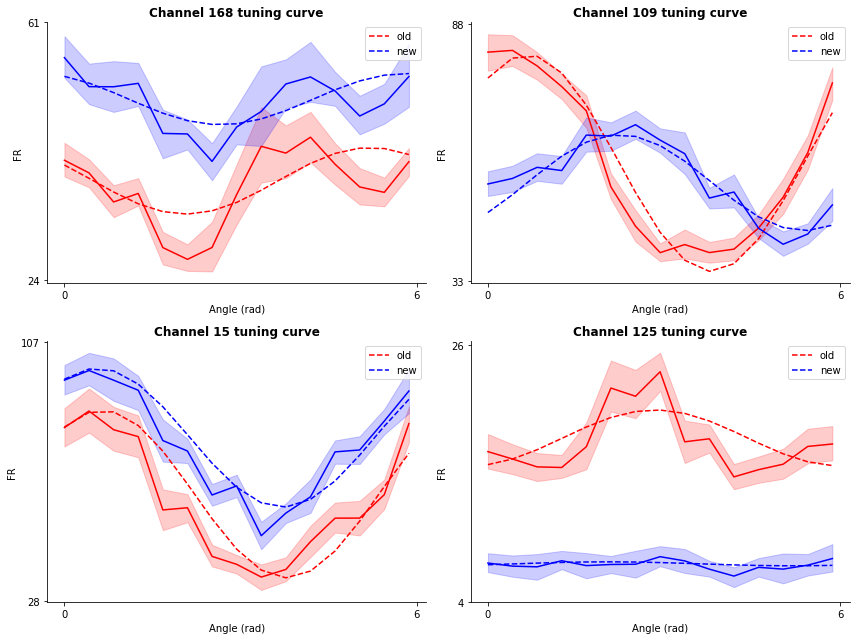

In [13]:
np.random.seed(10)

figSize(9, 12)

plt.figure()
for i, ch in enumerate([168, 109, 15, 125]):
    plt.subplot(2, 2, i + 1)

    for key, color in zip(['old', 'new'], ['r', 'b']):

        ch_preds  = cos_data['curves_' + key][ch].T
        ch_actual = cos_data['binned_rates_' + key][:, ch, :]
        
        plt.fill_between(labels, ch_actual[:, 1], ch_actual[:, 2], color=color, alpha=0.2)
        plt.plot(labels, ch_preds, c = color, linestyle = '--', label = key)        
        plt.plot(labels, np.nanmean(ch_actual[:], axis = 1), c = color)
    
    plt.legend()
    plt.title('Channel ' + str(ch) + ' tuning curve', fontweight = 'bold')
    
    plt.xlabel('Angle (rad)')
    plt.ylabel('FR')
    
    plt.xticks([0, 6])
    plt.yticks(np.round(plt.ylim(), 0))
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig(fig_path + 'T5_cosine_drift', format = 'pdf')
plt.show()